Calculating confidence intervals is unfortunately not included in the scipy optimizers. However, with a little bit of coding it is possible to make a nice regression plot showing confidence as well as prediction intervals. The solution is based on [pylangs answer to this SO question](https://stackoverflow.com/questions/27164114/show-confidence-limits-and-prediction-limits-in-scatter-plot)

A great resource for curve fitting with python is provided in [this noteboob from Marcos Duarte](http://nbviewer.jupyter.org/github/demotu/BMC/blob/master/notebooks/CurveFitting.ipynb)

The solution below works well if the residuals are normally distributed. It might be a good idea to use [lmfit](http://cars9.uchicago.edu/software/python/lmfit/confidence.html) for curve fitting because the package can provide with confidence intervals which are calculated via [bootstrapping](https://phe.rockefeller.edu/LogletLab/whitepaper/node17.html) and are more robust with respect to not normally distributed residuals. Furthermore, the lmfit package provides extensive fit diagnostics as well as 

The function below is pretty self explanatory. Follow the links provided above to learn more about confidence an prediction intervals.

In [40]:
import numpy as np
from scipy import stats, optimize
from matplotlib import pyplot as plt
plt.style.use(['seaborn-muted'])

In [41]:
def reg_plot(axis, model, popt, x_data, y_data, alpha=0.95):
    """Plots the confidence and prediction bounds for arbitrary models
       Assumption: residuals are distributed normally
       https://stackoverflow.com/questions/27164114/show-confidence-limits-and-prediction-limits-in-scatter-plot

       Inputs:
         axis .. axis handle on which the bands will be plotted
         model .. the fitted model f(x, *popt), has to return the fitted y values
         x_data .. independent data points
         y_data .. dependent data_pints
         alpha .. level of confidence

       Output
         returns nothing but plots the confidence and prediction band

    """
    # Statistics
    n = y_data.size                             # number of observations
    m = popt.size                               # number of parameters
    DF = n - m                                  # degrees of freedom
    t = stats.t.ppf(alpha, n - m)               # used for CI and PI bands

    # Estimates of Error in Data/Model
    yhat = model(x_data, *popt)
    resid = y_data - yhat
    chi2 = np.sum((resid/yhat)**2)             # chi-squared; estimates error in data
    chi2_red = chi2/DF                         # reduced chi-squared; measures goodness of fit
    s_err = np.sqrt(np.sum(resid**2)/DF)       # standard deviation of the error

    x2 = np.linspace(np.min(x_data), np.max(x_data), 100)
    y2 = model(x2, *popt)
    conf_int =  t * s_err * np.sqrt(1 / n + (x2 - np.mean(x_data))**2 /
                                    np.sum((x_data - np.mean(x_data))**2))
    pred_int = t * s_err * np.sqrt(1 + 1 / n + (x2 - np.mean(x_data))**2 /
                                   np.sum((x_data - np.mean(x_data))**2))

    #axis.plot(x_data, y_data, '.', alpha=0.5, color='C1')
    axis.plot(x2, y2, '-', alpha=0.5, color='k')

    axis.fill_between(x2, y2 + conf_int, y2 - conf_int, alpha=0.5 , color='C1',
                      label='95 % confidence bounds')

    axis.plot(x2, y2 + pred_int, 'k:', alpha=.5)
    axis.plot(x2, y2 - pred_int, 'k:', alpha=.5, label='95 % prediction bounds')
    axis.legend(loc='best')


Lets generate some data:

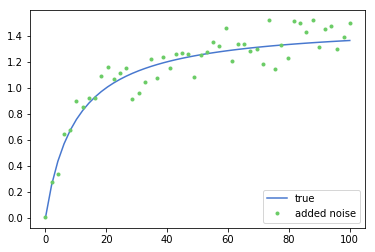

In [42]:
x = np.linspace(0,100)
a = 1.5
b = 0.1
y = a*b*x/(1 + x*b)
noise = np.random.normal(0, 0.1, size=len(y))
yn = y + noise
plt.plot(x, y, label = 'true')
plt.plot(x, yn, '.', label='added noise')
plt.legend(loc=4)

With the help of the function 'reg_plot' we can create a nice plot with one line of code:

/home/moritz/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in true_divide


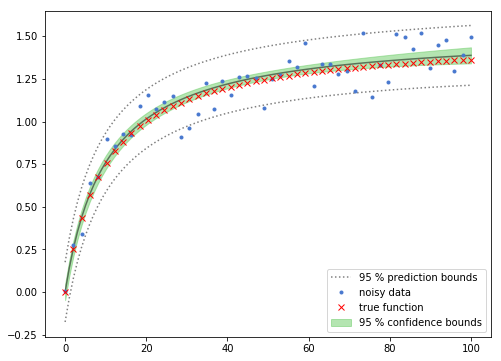

In [44]:
def cost_fun(x, a, b):
    y = a*b*x / (1 + a*x)
    return y

popt, pcov = optimize.curve_fit(cost_fun, x, yn)

# lets create some axis
fig, ax = plt.subplots(ncols=1, figsize=(8,6))

# the function automatically draws on the provided axis
reg_plot(ax, cost_fun, popt, x, yn)

# we can add the data for comparison
ax.plot(x, yn, '.', label='noisy data')
ax.plot(x, y, 'x',color='r',  label='true function')
ax.legend(loc='best')